In [1]:
from Bio.SeqIO.FastaIO import SimpleFastaParser as sfp
import os, sys
import numpy as np
import pandas as pd

import config_readwrite as crw

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

import warnings
warnings.filterwarnings("ignore")
import plot_params as pp

pp.fonts()

('sans-serif', 'Arial', 18)

# config

In [2]:
# read
config, cfn = crw.read(os.path.join(os.path.dirname(os.getcwd()), "config.ini"))

In [3]:
CL = "HEPG2"
DATAHEPG2 = config["mpra"][f'{CL}.clean.transformed'] 

FASTA = config["mpra"]["fasta"]

MEME = config["meme"]["src"]
FIMO = config["fimo"]["src"]
RESULTS = config["path"]["results"]
BED = config["mpra"]["tile.bed"]

RE_MEME = os.path.join(RESULTS, "meme")
RE_MEME_CL = os.path.join(RE_MEME, CL)

# make the results
for dirname in [RE_MEME, RE_MEME_CL]:
    if os.path.exists(dirname) is False:
        os.mkdir(dirname)

# append meme path
sys.path.append(MEME)

# change directory 
os.chdir(RE_MEME_CL)

In [4]:
# write

section = "meme"

config[section][f'results'] = RE_MEME
config[section][CL] = RE_MEME_CL

crw.write(config, cfn)

# load data

In [5]:
def openAndFilter(file_name):
    df = pd.read_csv(file_name, sep='\t')  # (58333, 38)
    print("before filtering", file_name,  df.shape)
    df = df.loc[~df["label"].str.contains("Synthetic")].reset_index(
        drop=True)  # (26803, 38)
    print("filter out synthetics", df.shape)
    df = df.loc[~df["label"].str.contains("Pos")].reset_index(
        drop=True)  # (26659, 38)
    print("filter out positive controls", df.shape, '\n\n')

    return df

In [6]:
#hepg2 = openAndFilter(DATAHEPG2)
bj = openAndFilter(DATAHEPG2)

before filtering /wynton/group/ahituv/fongsl/projects/US/data/full_hepg2_MPRA.clean.transformed.csv (58617, 34)
filter out synthetics (26998, 34)
filter out positive controls (26852, 34) 




In [7]:
bj.shape

(26852, 34)

In [8]:
enh = pd.read_csv(BED, sep='\t')
enh.head()

,name,enh.id,enh.name
0,hob_k27ac_down_chr1:826978-827247,chr1:826978-827704,enh.0
1,hob_k27ac_down_chr1:827110-827379,chr1:826978-827704,enh.0
2,hob_k27ac_down_chr1:827377-827646,chr1:826978-827704,enh.0
3,hob_k27ac_down_chr1:827435-827704,chr1:826978-827704,enh.0
4,hob_k27ac_down_chr1:827891-828160,chr1:827891-828160,enh.1


In [9]:
bj = pd.merge(bj, enh, how="left")

# add direction 

In [10]:
def labelDirection(df):

    """label sequences with different directions of change between US and Control
    note

    neg.US_UP == US MPRA activity is negative, but less negative than CTRL MPRA activity, which is also negative
    pos.US_UP  == US MPRA activity is positive and more positive than CTRL MPRA activity, which is also positive. 
    US_UP == US activity is positive and higher than CTRL MPRA activity, which is negative. 
    """
    df["direction"] = None

    # Pos values only
    df.loc[(df["l2.ratio.mean.us"] > 0) &
           (df["l2.ratio.mean.ctrl"] > 0) &
           (df["delta.mean"] > 0),
           "direction"] = "Pos.US_UP"

    df.loc[(df["l2.ratio.mean.us"] > 0) &
           (df["l2.ratio.mean.ctrl"] > 0) &
           (df["delta.mean"] < 0),
           "direction"] = "Pos.CTRL_UP"

    # Negtaive values only
    df.loc[(df["l2.ratio.mean.us"] < 0) &
           (df["l2.ratio.mean.ctrl"] < 0) &
           (df["delta.mean"] > 0),
           "direction"] = "Neg.CTRL_DOWN"

    df.loc[(df["l2.ratio.mean.us"] < 0) &
           (df["l2.ratio.mean.ctrl"] < 0) &
           (df["delta.mean"] < 0),
           "direction"] = "Neg.US_DOWN"

    # crossing zero values only
    df.loc[(df["l2.ratio.mean.us"] > 0) &
           (df["l2.ratio.mean.ctrl"] < 0) &
           (df["delta.mean"] > 0),
           "direction"] = "US_UP"

    df.loc[(df["l2.ratio.mean.us"] < 0) &
           (df["l2.ratio.mean.ctrl"] > 0) &
           (df["delta.mean"] < 0),
           "direction"] = "CTRL_UP"

    print(df.loc[df["direction"] != None, ["l2.ratio.mean.ctrl",
          "l2.ratio.mean.us", 'delta.mean', "direction"]].sample(n=20))
    return df


In [11]:
bj = labelDirection(bj)

       l2.ratio.mean.ctrl  l2.ratio.mean.us  delta.mean      direction
19412            0.059264          0.201428    0.142165      Pos.US_UP
18332           -0.730792         -0.750537   -0.019745    Neg.US_DOWN
21779           -0.042939         -0.062684   -0.019745    Neg.US_DOWN
6284             0.255391          0.320886    0.065495      Pos.US_UP
7176             0.409186          0.416065    0.006879      Pos.US_UP
2541             0.252767          0.329215    0.076448      Pos.US_UP
2010            -0.785828         -0.827450   -0.041622    Neg.US_DOWN
7284             0.317812          0.108664   -0.209148    Pos.CTRL_UP
5836            -0.650306         -0.723182   -0.072875    Neg.US_DOWN
16678            0.007651         -0.037604   -0.045255        CTRL_UP
9321             0.170516          0.348737    0.178221      Pos.US_UP
4028             0.100933          0.002071   -0.098862    Pos.CTRL_UP
17479            0.368047          0.409028    0.040981      Pos.US_UP
18862 

In [12]:
set(bj["label"])

{'Differential_ATAC',
 'Differential_H3K27ac',
 'NegCtl_Ilias_MPRA',
 'NegCtl_Vikram_MPRA',
 'Non-differential',
 'Promoter_DEG',
 'Shuffle'}

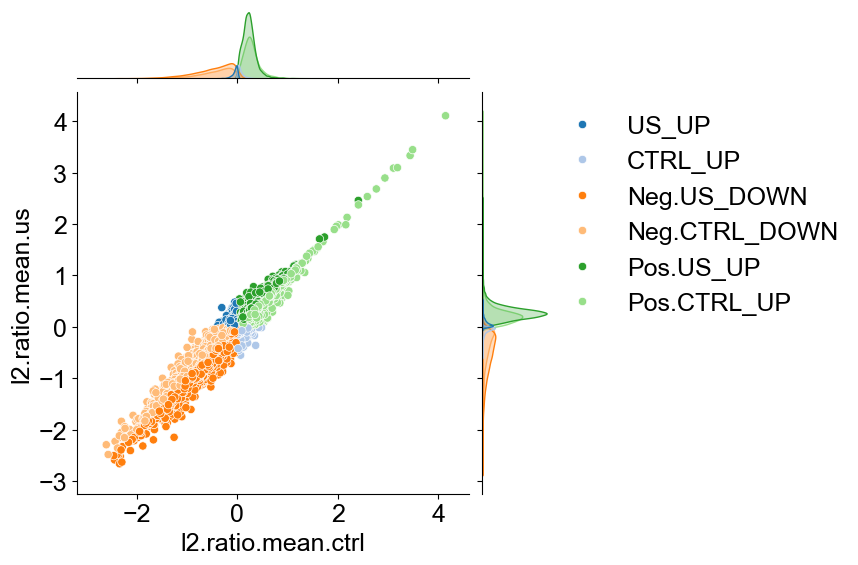

In [13]:
# 
#fig,ax = plt.subplots(figsize=(6,6))
hue_order = ['US_UP',
             'CTRL_UP',
             'Neg.US_DOWN',
             'Neg.CTRL_DOWN',
             'Pos.US_UP',
             'Pos.CTRL_UP',
             ]

g = sns.jointplot(x="l2.ratio.mean.ctrl", y="l2.ratio.mean.us",
                  data=bj, hue="direction", hue_order=hue_order,
                  palette='tab20'
                 )
g.ax_joint.legend(frameon=False, bbox_to_anchor=(2, 1))

# US up - hepg2

## functions

In [14]:
def getDfDirectionSub(df, direction):
    """subset dataframe by directino of effect"""

    cols = ["name", "label", "l2.ratio.mean.ctrl",
        'l2.ratio.mean.us', "delta.mean", "direction"]

    df = df.loc[df["direction"] == direction, cols].sort_values(
        by='l2.ratio.mean.us', ascending=False).copy()

    return df


def getQuantileDelta(df, top_quantile, base_df, shuf_bkgd=False):
    """subset dataframe by delta.mean top/bottom quantiles, return dataframes, list of names"""

    # top quantile of delta.means
    pos = df.loc[df["delta.mean"] >=
                     df["delta.mean"].quantile(top_quantile)].copy()

    # pos list of names
    pos_names = list(pos["name"])

    # bottom quantile of delta.means.
    neg = df.loc[df["delta.mean"] <=
                     df["delta.mean"].quantile(1-top_quantile)].copy()
    if shuf_bkgd is True:
        shuf = base_df.loc[base_df['label'] ==
            "Shuffle"].copy().drop_duplicates()
        neg = pd.concat([neg, shuf])

    # neg list of names
    neg_names = list(neg["name"])

    return pos, pos_names, neg, neg_names


def makeQuantileFasta(pos_names, neg_names, direction, re, top_quantile, exp_name, fa):
    """write fastas for each quantile based on list of sequence names"""

    bottom_quantile = round(1-top_quantile, 1)

    # files to write
    FA_POS = os.path.join(re, f"{exp_name}.{direction}.pos.{top_quantile}.fa")
    FA_NEG = os.path.join(
        re, f"{exp_name}.{direction}.neg.{bottom_quantile}.fa")

    # write positive, negative names and sequences
    for names, fa_write in [(pos_names, FA_POS), (neg_names, FA_NEG)]:

        # filter and write fasta function
        filterWriteFasta(fa_write, fa, names)

    return FA_POS, FA_NEG


def filterWriteFasta(fa_write_file, source_fa, seq_id_list):
    """provide file to write, source fasta, and sequence list"""
    fa_writer = open(fa_write_file, "w")  # open fa file to write

    with open(source_fa, "r") as reader:  # open the full fa file
        for value in sfp(reader):
            seq_id, seq = value  # get sequence id, sequence
            if seq_id in seq_id_list:  # filter for sequences in pos/neg name list
                # write those sequences to fa
                fa_writer.write(f'>{seq_id}\n{seq}\n')
    fa_writer.close()

def getEnhSet(df, name_set):
    """return list of enhancer names and linked tiles to prevent data leakage"""
    enh_names = df.loc[df["name"].isin(name_set), "enh.name"].unique()
    linkedtiles = df.loc[df["enh.name"].isin(enh_names), "name"].unique()
    
    return enh_names, linkedtiles

def runFimo(fimo, meme_txt, fa, direction, quantile):

    OUTDIR = f"./fimo/{direction}.{quantile}"
    cmd = " ".join([fimo,
                    "--oc",
                    OUTDIR,
                    meme_txt,
                    fa,

                    ])
    os.system(cmd)

    return OUTDIR

## Experiment 1: Motif discovery on top 10% of US-increasing sequences v. bottom 10% of US-increasing sequences. 
    - Hyp - top 10% reflects true signal, bottom 10% is noise. Motifs enriched in the top 10% of US-sensitive elements not found in bottom 10% are likely important for US-dependent TF binding. 
    - Data Universe: BJ MPRA, all of the sequences where the contrl MPRA value is negative and US MPRA value is positive

In [15]:
EXP_NAME ="exp1"
DIRECTION = "US_UP"
df = bj
TOP_QUANTILE = 0.9
BOTTOM_QUANTILE = round((1-TOP_QUANTILE),1)

### US-increasing sequences only

In [16]:
### subset df by direction. 

df_dir = getDfDirectionSub(df, DIRECTION)

### top and bottom 10% of direction changes. 

# top quantile of delta.means
pos, pos_names, neg, neg_names = getQuantileDelta(df_dir, TOP_QUANTILE, df, True)


# make fasta files from quantiles. 
FA_POS, FA_NEG = makeQuantileFasta(pos_names, neg_names, DIRECTION, RE_MEME_CL, TOP_QUANTILE, EXP_NAME, FASTA)

# add to config
config[section][f'{CL}.{DIRECTION}.{TOP_QUANTILE}.fa'] = FA_POS
config[section][f'{CL}.{DIRECTION}.{BOTTOM_QUANTILE}.fa'] = FA_NEG

exp1up, exp1down = pos_names, neg_names

In [17]:
neg

,name,label,l2.ratio.mean.ctrl,l2.ratio.mean.us,delta.mean,direction,seq.id,ratio.med.ctrl,label.ctrl,ratio.1.ctrl,...,l2.ratio.1.us,l2.ratio.2.us,l2.ratio.3.us,l2.ratio.med.ctrl,l2.ratio.std.ctrl,l2.ratio.med.us,l2.ratio.std.us,delta.med,enh.id,enh.name
25319,k562_atac_down_chr7:157814718-157814987,Differential_ATAC,-0.004086,0.026252,0.030338,US_UP,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1021,bj_atac_down_chr18:27844525-27844794,Differential_ATAC,-0.000027,0.025435,0.025462,US_UP,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13529,hob_k27ac_down_chr1:51558472-51558741,Differential_H3K27ac,-0.003979,0.023748,0.027727,US_UP,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15844,hob_k27ac_up_chr12:15701631-15701900,Differential_H3K27ac,-0.000903,0.022670,0.023574,US_UP,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3327,hepg2_atac_down_chr11:61671695-61671964,Differential_ATAC,-0.007558,0.022386,0.029945,US_UP,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
705,Neg_shuffle_98_SYNTHETIC:_The_motif_CAGGAACGGG...,Shuffle,-1.329627,-1.706157,-0.376531,Neg.US_DOWN,seq.1054,0.399982,-1.0,0.362483,...,-1.505648,-1.230808,-2.382016,-1.399826,0.180060,-1.505648,0.601226,-0.105822,NaN,NaN
706,Neg_shuffle_98_bj_k27ac_up_chr14:50955859-5095...,Shuffle,-1.493218,-1.470449,0.022769,Neg.CTRL_DOWN,seq.1055,0.356602,-1.0,0.313516,...,-1.186649,-1.529894,-1.694803,-1.423459,0.157350,-1.529894,0.259240,-0.106436,chr14:50955327-50956128,enh.2989
707,"Neg_shuffle_99_SYNTHETIC:_Added_GGCGCATGAG,CCC...",Shuffle,0.020594,-0.123598,-0.144193,CTRL_UP,seq.1056,1.019474,0.0,1.142338,...,0.070014,-0.464336,0.023528,0.031987,0.177366,0.023528,0.296002,-0.008460,NaN,NaN
708,"Neg_shuffle_9_SYNTHETIC:_Added_GGTGACTG,GAATGG...",Shuffle,0.063734,0.024923,-0.038810,Pos.CTRL_UP,seq.1058,1.046908,0.0,1.127972,...,0.050394,-0.005666,0.030042,0.044139,0.101627,0.030042,0.028378,-0.014097,NaN,NaN


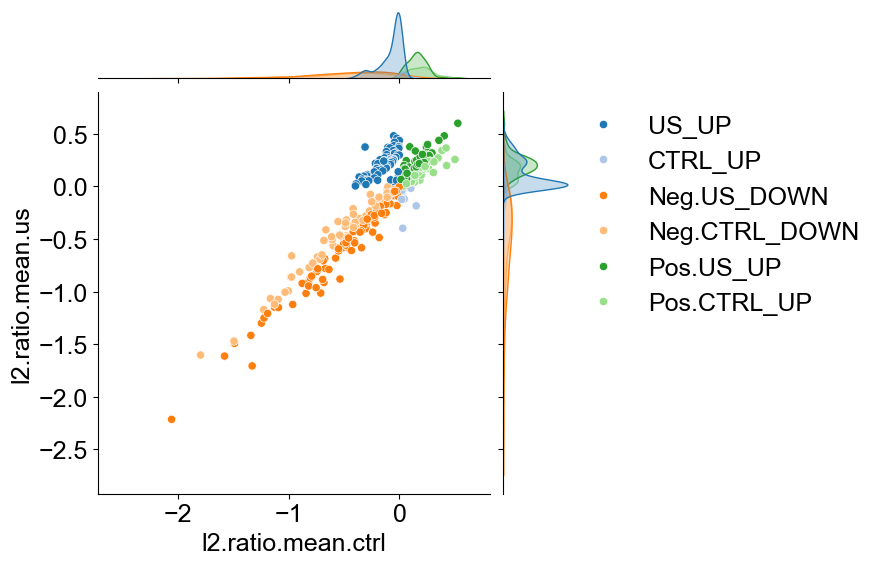

In [18]:
plot = pd.concat([pos, neg])
# fig,ax = plt.subplots(figsize=(6,6))
hue_order = ['US_UP',
             'CTRL_UP',
             'Neg.US_DOWN',
             'Neg.CTRL_DOWN',
             'Pos.US_UP',
             'Pos.CTRL_UP',
             ]

g = sns.jointplot(x="l2.ratio.mean.ctrl", y="l2.ratio.mean.us",
                  data=plot, hue="direction", hue_order=hue_order,
                  palette='tab20'
                 )
g.ax_joint.legend(frameon=False, bbox_to_anchor=(2, 1))

### sanity check - delta scores are larger than expected from shuffle.  

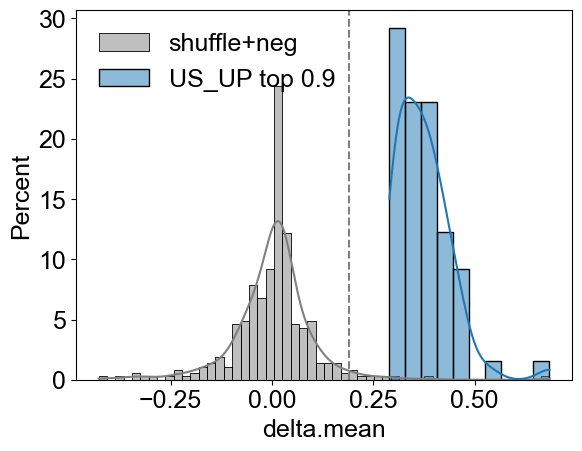

In [19]:
shuf = bj.loc[bj["label"] == "Shuffle"]
genome = bj.loc[bj["label"] != "Shuffle"]

fig, ax = plt.subplots()

"""
sns.histplot(x="delta.mean", data=df_dir,
             label=f"{DIRECTION}", stat="percent", kde=True,
             color="w", common_norm=False
            )
            
"""
sns.histplot(x="delta.mean", data=neg, label="shuffle+neg", kde=True,
             stat="percent", color="grey", common_norm=False)

# draw upper 97.5% line
ax.axvline(neg["delta.mean"].quantile(0.975), ls = "--", c="grey")

sns.histplot(x="delta.mean", data=pos, label=f"{DIRECTION} top {TOP_QUANTILE}",
             kde=True,common_norm=False,
             stat="percent")
plt.legend(frameon=False, loc="upper left")



#### delta.mean stats - shuf, us_up

In [20]:
neg["delta.mean"].quantile(0.975), pos["delta.mean"].describe()

(0.19086911357003933,
 count    65.000000
 mean      0.372931
 std       0.067920
 min       0.289691
 25%       0.319460
 50%       0.364804
 75%       0.405552
 max       0.684540
 Name: delta.mean, dtype: float64)

### MEME motif discovery

#### MEME params

In [21]:
# MEME PARAMS - https://meme-suite.org/meme/doc/meme.html?man_type=web
OUTPUT_DIR = RE_MEME_CL
OBJ_FUN = "de" # differential enrichment, uses multiple hypergeometric test (mhg) as stat to measure enrichment
TEST = "mhg"
MIN_WIDTH = 10
MAX_WIDTH = 15

N_SITES = 10  # find motifs with N sites
N_MOTIFS = 3 # n motifes to find

In [22]:
RE_MEME_CL

'/wynton/group/ahituv/fongsl/projects/US/results/meme/HEPG2'

#### MEME cmd, run

In [24]:
args = [FA_POS,
        "-oc", OUTPUT_DIR,
        '-objfun', OBJ_FUN,
        "-neg", FA_NEG,
        "-dna",  # use DNA alphabet
        "-minw", MIN_WIDTH,
        '-maxw', MAX_WIDTH,
        "-allw",  # test starts for all widths
        "-nsites", N_SITES,  # number of sites for each motif
        "-nmotifs", N_MOTIFS
        ]

# add meme args together
cmd = [MEME] + args

# transform into a str
cmd = " ".join([str(i) for i in cmd])

# run command
os.system(cmd)

# write the output meme file
MEME_TXT = os.path.join(RE_MEME_CL, f"{CL}.{DIRECTION}.{TOP_QUANTILE}.meme.txt")

# rename the membe file
os.system(f"mv meme.txt {CL}.{DIRECTION}.{TOP_QUANTILE}.meme.txt")

config[section][f'{CL}.{DIRECTION}.{TOP_QUANTILE}.meme'] = MEME_TXT

crw.write(config, cfn)

The output directory '/wynton/group/ahituv/fongsl/projects/US/results/meme/HEPG2' already exists.
Its contents will be overwritten.
BACKGROUND: using background model of order 0
PRIMARY (de): n 65 p0 32 p1 16 p2 17
CONTROL (de): n 367 c0 65 c1 151 c2 151
SEQUENCE GROUP USAGE-- Starts/EM: p0 vs c0; Trim: p1 vs c1; pvalue: p2 vs c1,c2; nsites: p0,p1,p2 vs c0,c1,c2
SEEDS: maxwords 17550 highwater mark: seq 32 pos 260
all widths from min to max

seqs=    65, min_w= 270, max_w=  270, total_size=    17550

motif=1
SEED DEPTHS: estimated from data
SEED WIDTHS: 10 11 12 13 14 15
em: w=  15, psites=  10, iter=  30 
motif=2
SEED DEPTHS: estimated from data
SEED WIDTHS: 10 11 12 13 14 15
em: w=  15, psites=  10, iter=  30 
motif=3
SEED DEPTHS: estimated from data
SEED WIDTHS: 10 11 12 13 14 15
em: w=  15, psites=  10, iter=  40 


### MEME output
     /wynton/group/ahituv/fongsl/projects/US/results/meme/HepG1

### Fimo on full dataset

        bottom 0.1 US_UP bkgd discovered motifs
        CAGRCTCTCS
        CCTGKRTGWGW
        GAGRAGVMAGCMK
        
        bottom0.1 US_UP and shuffle bkgd
        AGGAGGMAGC
        AGRSCCCAGC
        CARRCTCTCCT

In [32]:
OUTDIR_TOP =  runFimo(FIMO, MEME_TXT, FA_POS, DIRECTION, TOP_QUANTILE)
OUTDIR_BOTTOM =  runFimo(FIMO, MEME_TXT, FA_NEG, DIRECTION, BOTTOM_QUANTILE)

Using motif +GRGRRGGGCTGAGDG of width 15.
Using motif -GRGRRGGGCTGAGDG of width 15.
Computing q-values.
# Computing q-values.
#   Estimating pi_0 from a uniformly sampled set of 10000 p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.918374
#   Estimated pi_0=0.926708
Using motif +TCTSCSCAVRG of width 11.
Using motif -TCTSCSCAVRG of width 11.
Computing q-values.
# Computing q-values.
#   Estimating pi_0 from a uniformly sampled set of 10000 p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.865246
#   Estimated pi_0=0.865246
Using motif +KSAGSCCWGGCYS of width 13.
Using motif -KSAGSCCWGGCYS of width 13.
Computing q-values.
# Computing q-values.
#   Estimating pi_0 from a uniformly sampled set of 10000 p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.8256
#   Estimated pi_0=0.830185
Using motif +GRGRRGGGCTGAGDG of width 15.
Using motif -GRGRRGGGCTGAGDG of width 15.
Computing q-values.
# Computing q-values.
#   Estimating pi_0 from a uniformly sampled set of 10000 p-values.
#   

In [33]:
OUTDIR_BOTTOM

'./fimo/US_UP.0.1'

In [34]:
bottom_pred = os.path.join(OUTDIR_BOTTOM, "fimo.tsv")
top_pred = os.path.join(OUTDIR_TOP, "fimo.tsv")

tdf = pd.read_csv(top_pred, sep='\t')
tdf["quantile"] = 'top0.9'
tdf["-log10q"]  = -1*np.log10(tdf["q-value"])
print(tdf.shape)


bdf = pd.read_csv(bottom_pred, sep='\t')
bdf["quantile"] = 'shuf'
bdf["-log10q"]  = -1*np.log10(bdf["q-value"])
print(bdf.shape)

(98, 12)
(85, 12)


In [35]:
# concatenate the top and bottom values
plot = pd.concat([tdf, bdf])

plot = plot.loc[~plot["motif_alt_id"].isna()]

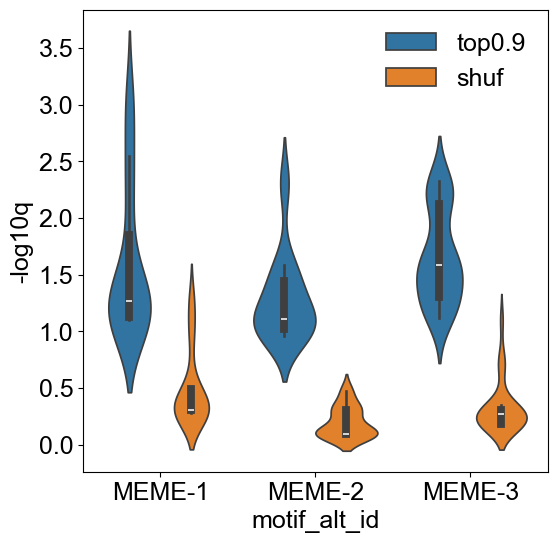

In [36]:
fig, ax= plt.subplots( figsize = (6,6))
sns.violinplot(x="motif_alt_id", y='-log10q', data= plot, hue="quantile", 
               order = ["MEME-1", "MEME-2", "MEME-3"])
#ax.set(ylim=(-0.10,2.75))
ax.legend(frameon=False, loc='upper right')

In [37]:
IDS = ["MEME-1", "MEME-2", "MEME-3"]
VAL =  "-log10q" #"score"
for ID in IDS: 

    a = tdf.loc[tdf["motif_alt_id"]==ID, VAL]
    b = bdf.loc[bdf["motif_alt_id"]==ID, VAL]
    print(ID, stats.mannwhitneyu(a,b))

MEME-1 MannwhitneyuResult(statistic=1235.0, pvalue=3.015528727392932e-11)
MEME-2 MannwhitneyuResult(statistic=460.0, pvalue=1.6464196018580995e-08)
MEME-3 MannwhitneyuResult(statistic=945.0, pvalue=1.8364366127394847e-11)


# Validation

## Experiment 2: are motifs discovered in US_UP also discovered in POS.US_UP?
    - hypothesis: top motifs in us_up are also driving increased activity in pos.US_up. 
    - approach: use FIMO to discover US_UP motifs in other data. 
    - data universe: sequences with positive baseline activity that increase activity w/ US

In [38]:
EXP_NAME ="exp2"
DIRECTION = "Pos.US_UP"

### pos.us_up sequences only

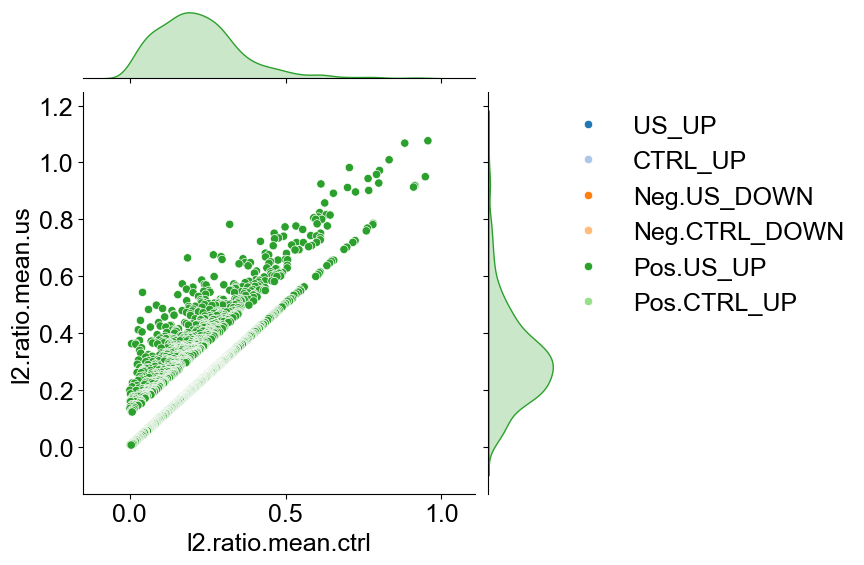

In [39]:
### subset df by direction. 

df_dir = getDfDirectionSub(df, DIRECTION)

### top and bottom 10% of direction changes. 

# top quantile of delta.means, no shuffle data leakage
pos, pos_names, neg, neg_names = getQuantileDelta(df_dir, TOP_QUANTILE, df, False)

plot = pd.concat([pos, neg])
# fig,ax = plt.subplots(figsize=(6,6))
hue_order = ['US_UP',
             'CTRL_UP',
             'Neg.US_DOWN',
             'Neg.CTRL_DOWN',
             'Pos.US_UP',
             'Pos.CTRL_UP',
             ]

g = sns.jointplot(x="l2.ratio.mean.ctrl", y="l2.ratio.mean.us",
                  data=plot, hue="direction", hue_order=hue_order,
                  palette='tab20'
                 )
g.ax_joint.legend(frameon=False, bbox_to_anchor=(2, 1))

### clean up data leakage
- tiled enhancers which may have overlapping information

In [40]:
# get enh ids, linked tiles from exp1 dataset
exp1pos_enhnames, exp1pos_linkedtiles = getEnhSet(bj, exp1up)
exp1neg_enhnames, exp1neg_linkedtiles = getEnhSet(bj, exp1down)

In [41]:
# remove exp 1 linked tiles
pos_names_clean = set(pos_names).difference(set(exp1pos_linkedtiles))
neg_names_clean = set(neg_names).difference(set(exp1neg_linkedtiles))

# make fasta files from quantiles. 
FA_POS, FA_NEG = makeQuantileFasta(pos_names_clean, neg_names_clean, DIRECTION, RE_MEME_CL, TOP_QUANTILE, EXP_NAME, FASTA)

# add to config
config[section][f'{CL}.{DIRECTION}.{TOP_QUANTILE}.fa'] = FA_POS
config[section][f'{CL}.{DIRECTION}.{BOTTOM_QUANTILE}.fa'] = FA_NEG

crw.write(config, cfn)

### sanity check

In [42]:
pos.shape, neg.shape

((945, 6), (944, 6))

In [43]:
neg["delta.mean"].describe()

count    944.000000
mean       0.003638
std        0.002107
min        0.000006
25%        0.001829
50%        0.003624
75%        0.005473
max        0.007161
Name: delta.mean, dtype: float64

(0.19817722111906833,
 count    945.000000
 mean       0.175896
 std        0.059599
 min        0.115296
 25%        0.131689
 50%        0.156852
 75%        0.202283
 max        0.502470
 Name: delta.mean, dtype: float64)

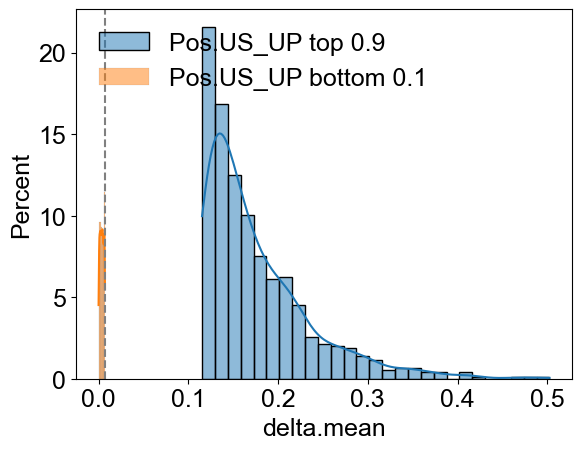

In [44]:
shuf = bj.loc[bj["label"] == "Shuffle"]
genome = bj.loc[bj["label"] != "Shuffle"]

fig, ax = plt.subplots()

"""
sns.histplot(x="delta.mean", data=df_dir,
             label=f"{DIRECTION}", stat="percent", kde=True,
             color="w", common_norm=False
            )
            
"""
#sns.histplot(x="delta.mean", data=shuf, label="shuffle", kde=True,
 #            stat="percent", color="grey", common_norm=False)
sns.histplot(x="delta.mean", data=pos, label=f"{DIRECTION} top {TOP_QUANTILE}",
             kde=True,common_norm=False,
             stat="percent")
sns.histplot(x="delta.mean", data=neg, label=f"{DIRECTION} bottom {BOTTOM_QUANTILE}",
             kde=True,common_norm=False,
             stat="percent")
# draw upper 97.5% line
ax.axvline(neg["delta.mean"].quantile(0.975), ls = "--", c="grey")

plt.legend(frameon=False, loc="upper left")



shuf["delta.mean"].quantile(0.975), pos["delta.mean"].describe()

### Fimo

In [45]:
OUTDIR_TOP =  runFimo(FIMO, MEME_TXT, FA_POS, DIRECTION, TOP_QUANTILE)
OUTDIR_BOTTOM =  runFimo(FIMO, MEME_TXT, FA_NEG, DIRECTION, BOTTOM_QUANTILE)

Using motif +GRGRRGGGCTGAGDG of width 15.
Using motif -GRGRRGGGCTGAGDG of width 15.
Computing q-values.
# Computing q-values.
#   Estimating pi_0 from a uniformly sampled set of 10000 p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.930606
#   Estimated pi_0=0.930833
Using motif +TCTSCSCAVRG of width 11.
Using motif -TCTSCSCAVRG of width 11.
Computing q-values.
# Computing q-values.
#   Estimating pi_0 from a uniformly sampled set of 10000 p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.886909
#   Estimated pi_0=0.89
Using motif +KSAGSCCWGGCYS of width 13.
Using motif -KSAGSCCWGGCYS of width 13.
Computing q-values.
# Computing q-values.
#   Estimating pi_0 from a uniformly sampled set of 10000 p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.873069
#   Estimated pi_0=0.884655
Using motif +GRGRRGGGCTGAGDG of width 15.
Using motif -GRGRRGGGCTGAGDG of width 15.
Computing q-values.
# Computing q-values.
#   Estimating pi_0 from a uniformly sampled set of 10000 p-values.
#   Es

### FET enrichment

(975, 12)
(307, 12)


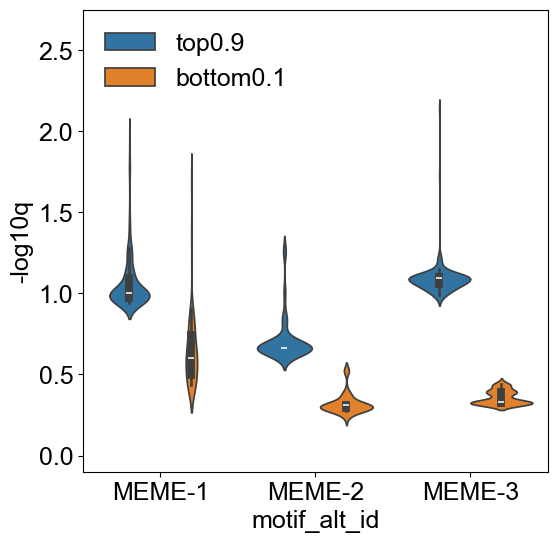

In [46]:
bottom_pred = os.path.join(OUTDIR_BOTTOM, "fimo.tsv")
top_pred = os.path.join(OUTDIR_TOP, "fimo.tsv")

tdf = pd.read_csv(top_pred, sep='\t')
tdf["quantile"] = 'top0.9'
tdf["-log10q"]  = -1*np.log10(tdf["q-value"])
print(tdf.shape)
tdf.head()

bdf = pd.read_csv(bottom_pred, sep='\t')
bdf["quantile"] = 'bottom0.1'
bdf["-log10q"]  = -1*np.log10(bdf["q-value"])
print(bdf.shape)
bdf.head()

# concatenate the top and bottom values
plot = pd.concat([tdf, bdf])
plot = plot.loc[~plot["motif_alt_id"].isna()]
fig, ax= plt.subplots( figsize = (6,6))
sns.violinplot(x="motif_alt_id", y='-log10q', data= plot, hue="quantile", 
               order = ["MEME-1", "MEME-2", "MEME-3"])
ax.set(ylim=(-0.10,2.75))
ax.legend(frameon=False, loc='upper left')

In [47]:
IDS = ["MEME-1", "MEME-2", "MEME-3"]
VAL =  "-log10q" #"score"
for ID in IDS: 

    a = tdf.loc[tdf["motif_alt_id"]==ID, VAL]
    b = bdf.loc[bdf["motif_alt_id"]==ID, VAL]
    print(ID, stats.mannwhitneyu(a,b))

MEME-1 MannwhitneyuResult(statistic=46812.0, pvalue=4.1723832832932585e-55)
MEME-2 MannwhitneyuResult(statistic=14580.0, pvalue=8.400581999713667e-44)
MEME-3 MannwhitneyuResult(statistic=39382.0, pvalue=1.1113653965805487e-53)


In [48]:
plot.groupby(["motif_alt_id", "quantile"]).count()

motif_id  sequence_name  start  stop  strand  score  \
motif_alt_id quantile                                                         
MEME-1       bottom0.1       126            126    126   126     126    126   
             top0.9          386            386    386   386     386    386   
MEME-2       bottom0.1        81             81     81    81      81     81   
             top0.9          180            180    180   180     180    180   
MEME-3       bottom0.1        97             97     97    97      97     97   
             top0.9          406            406    406   406     406    406   

                        p-value  q-value  matched_sequence  -log10q  
motif_alt_id quantile                                                
MEME-1       bottom0.1      126      126               126      126  
             top0.9         386      386               386      386  
MEME-2       bottom0.1       81       81                81       81  
             top0.9         180      180               180      180  
MEME-3       bottom0.1       97       97                97       97  
             top0.9         406      406               406      406

In [49]:
# how many significant motifs in each group?
plot.loc[plot["q-value"]<=0.05].groupby(["motif_alt_id", "quantile"]).count()

motif_id  sequence_name  start  stop  strand  score  \
motif_alt_id quantile                                                         
MEME-1       bottom0.1         4              4      4     4       4      4   
             top0.9           20             20     20    20      20     20   
MEME-3       top0.9            4              4      4     4       4      4   

                        p-value  q-value  matched_sequence  -log10q  
motif_alt_id quantile                                                
MEME-1       bottom0.1        4        4                 4        4  
             top0.9          20       20                20       20  
MEME-3       top0.9           4        4                 4        4

## Experiment 3 - motif enrichment in repressed sequences? 

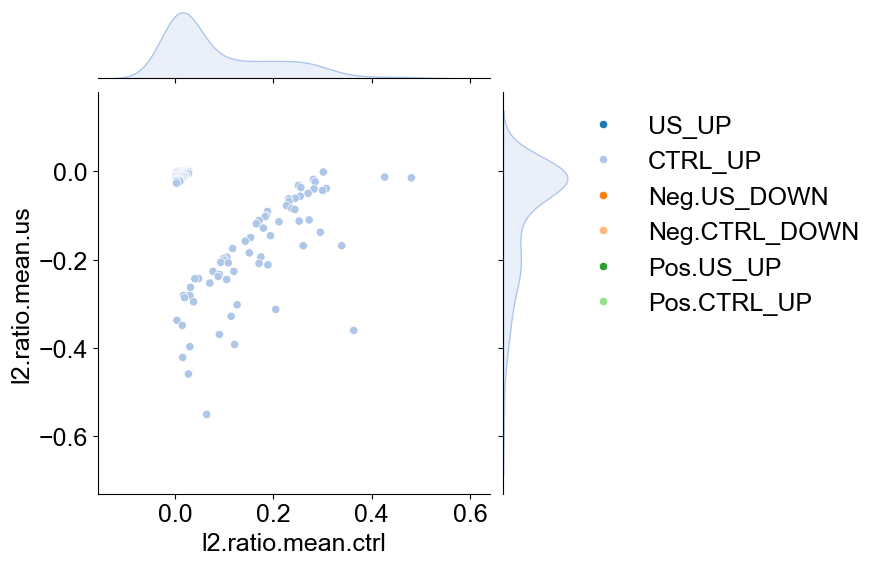

In [50]:
EXP_NAME ="exp3"
DIRECTION = "CTRL_UP"

### subset df by direction. 

df_dir = getDfDirectionSub(df, DIRECTION)

### top and bottom 10% of direction changes. 

# top quantile of delta.means
pos, pos_names, neg, neg_names = getQuantileDelta(df_dir, TOP_QUANTILE, df, False)

plot = pd.concat([pos, neg])
# fig,ax = plt.subplots(figsize=(6,6))
hue_order = ['US_UP',
             'CTRL_UP',
             'Neg.US_DOWN',
             'Neg.CTRL_DOWN',
             'Pos.US_UP',
             'Pos.CTRL_UP',
             ]

g = sns.jointplot(x="l2.ratio.mean.ctrl", y="l2.ratio.mean.us",
                  data=plot, hue="direction", hue_order=hue_order,
                  palette='tab20'
                 )
g.ax_joint.legend(frameon=False, bbox_to_anchor=(2, 1))

In [51]:
# get enh ids, linked tiles from exp1 dataset
exp1pos_enhnames, exp1pos_linkedtiles = getEnhSet(bj, exp1up)
exp1neg_enhnames, exp1neg_linkedtiles = getEnhSet(bj, exp1down)

(       l2.ratio.mean.ctrl  l2.ratio.mean.us  delta.mean
 count           69.000000         69.000000   69.000000
 mean             0.010536         -0.009858   -0.020394
 std              0.007144          0.006885    0.008103
 min              0.001025         -0.026823   -0.031964
 25%              0.003426         -0.015118   -0.027814
 50%              0.009550         -0.008993   -0.021278
 75%              0.015154         -0.004184   -0.014016
 max              0.027811         -0.000028   -0.003397,
        l2.ratio.mean.ctrl  l2.ratio.mean.us  delta.mean
 count           69.000000         69.000000   69.000000
 mean             0.170258         -0.185883   -0.356141
 std              0.106139          0.122265    0.084991
 min              0.003609         -0.551240   -0.724280
 25%              0.090087         -0.253358   -0.382790
 50%              0.170860         -0.184884   -0.323826
 75%              0.251148         -0.086508   -0.299964
 max              0.480763    

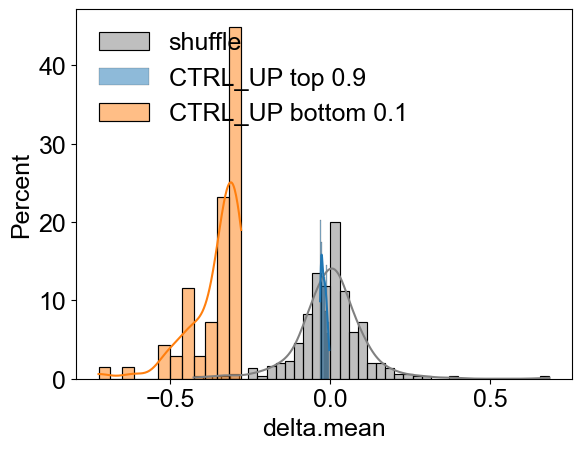

In [52]:
# remove exp 1 linked tiles
pos_names_clean = set(pos_names).difference(set(exp1pos_linkedtiles))
neg_names_clean = set(neg_names).difference(set(exp1neg_linkedtiles))

# make fasta files from quantiles. 
FA_POS, FA_NEG = makeQuantileFasta(pos_names_clean, neg_names_clean, DIRECTION, RE_MEME_CL, TOP_QUANTILE, EXP_NAME, FASTA)


# add to config
config[section][f'{CL}.{DIRECTION}.{TOP_QUANTILE}.fa'] = FA_POS
config[section][f'{CL}.{DIRECTION}.{BOTTOM_QUANTILE}.fa'] = FA_NEG

crw.write(config, cfn)

shuf = bj.loc[bj["label"] == "Shuffle"]
genome = bj.loc[bj["label"] != "Shuffle"]

fig, ax = plt.subplots()

"""
sns.histplot(x="delta.mean", data=df_dir,
             label=f"{DIRECTION}", stat="percent", kde=True,
             color="w", common_norm=False
            )
            
"""
sns.histplot(x="delta.mean", data=shuf, label="shuffle", kde=True,
             stat="percent", color="grey", common_norm=False)
sns.histplot(x="delta.mean", data=pos, label=f"{DIRECTION} top {TOP_QUANTILE}",
             kde=True,common_norm=False, #color="orange", 
             stat="percent")
sns.histplot(x="delta.mean", data=neg, label=f"{DIRECTION} bottom {BOTTOM_QUANTILE}",
             kde=True,common_norm=False, #color="blue",
             stat="percent")
plt.legend(frameon=False, loc="upper left")

shuf["delta.mean"].quantile(0.975), pos["delta.mean"].describe()

pos.describe(), neg.describe()

In [53]:
OUTDIR_TOP =  runFimo(FIMO, MEME_TXT, FA_POS, DIRECTION, TOP_QUANTILE)
OUTDIR_BOTTOM =  runFimo(FIMO, MEME_TXT, FA_NEG, DIRECTION, BOTTOM_QUANTILE)

Using motif +GRGRRGGGCTGAGDG of width 15.
Using motif -GRGRRGGGCTGAGDG of width 15.
Computing q-values.
# Computing q-values.
#   Estimating pi_0 from a uniformly sampled set of 10000 p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.983473
#   Estimated pi_0=0.988021
Using motif +TCTSCSCAVRG of width 11.
Using motif -TCTSCSCAVRG of width 11.
Computing q-values.
# Computing q-values.
#   Estimating pi_0 from a uniformly sampled set of 10000 p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.993029
#   Estimated pi_0=0.997387
Using motif +KSAGSCCWGGCYS of width 13.
Using motif -KSAGSCCWGGCYS of width 13.
Computing q-values.
# Computing q-values.
#   Estimating pi_0 from a uniformly sampled set of 10000 p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.984649
#   Estimated pi_0=0.988041
Using motif +GRGRRGGGCTGAGDG of width 15.
Using motif -GRGRRGGGCTGAGDG of width 15.
Computing q-values.
# Computing q-values.
#   Estimating pi_0 from a uniformly sampled set of 10000 p-values.
# 

(33, 12)
(73, 12)


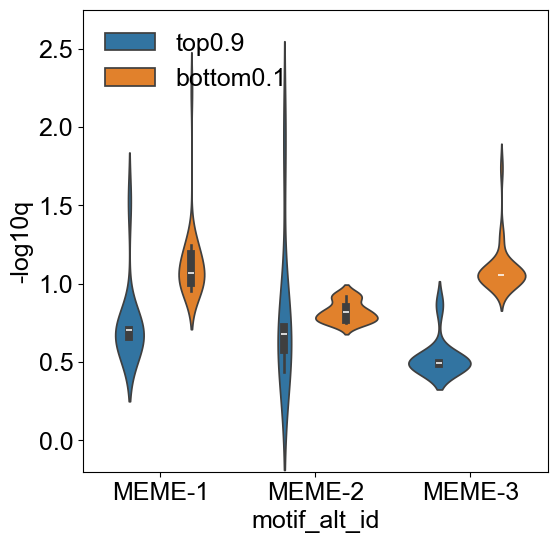

In [56]:
bottom_pred = os.path.join(OUTDIR_BOTTOM, "fimo.tsv")
top_pred = os.path.join(OUTDIR_TOP, "fimo.tsv")

tdf = pd.read_csv(top_pred, sep='\t')
tdf["quantile"] = 'top0.9'
tdf["-log10q"] = -1*np.log10(tdf["q-value"])
print(tdf.shape)
tdf.head()

bdf = pd.read_csv(bottom_pred, sep='\t')
bdf["quantile"] = 'bottom0.1'
bdf["-log10q"] = -1*np.log10(bdf["q-value"])
print(bdf.shape)
bdf.head()

# concatenate the top and bottom values
plot = pd.concat([tdf, bdf])
plot = plot.loc[~plot["motif_alt_id"].isna()]

fig, ax = plt.subplots(figsize=(6, 6))
sns.violinplot(x="motif_alt_id", y='-log10q', data=plot, hue="quantile",
               #hue_order=["bottom0.1", "top0.1"],
               order=["MEME-1", "MEME-2", "MEME-3"])
ax.set(ylim=(-0.20,2.75))
ax.legend(frameon=False, loc='upper left')

In [57]:
IDS = ["MEME-1", "MEME-2", "MEME-3"]
VAL =  "-log10q" #"score"
for ID in IDS: 

    a = tdf.loc[tdf["motif_alt_id"]==ID, VAL]
    b = bdf.loc[bdf["motif_alt_id"]==ID, VAL]
    print(ID, stats.mannwhitneyu(a,b))

MEME-1 MannwhitneyuResult(statistic=27.0, pvalue=3.060986007617133e-05)
MEME-2 MannwhitneyuResult(statistic=16.0, pvalue=0.003217527780981511)
MEME-3 MannwhitneyuResult(statistic=0.0, pvalue=1.955554587104246e-06)


In [58]:
plot.groupby(["motif_alt_id", "quantile"]).count()

motif_id  sequence_name  start  stop  strand  score  \
motif_alt_id quantile                                                         
MEME-1       bottom0.1        28             28     28    28      28     28   
             top0.9           12             12     12    12      12     12   
MEME-2       bottom0.1        16             16     16    16      16     16   
             top0.9            8              8      8     8       8      8   
MEME-3       bottom0.1        26             26     26    26      26     26   
             top0.9           10             10     10    10      10     10   

                        p-value  q-value  matched_sequence  -log10q  
motif_alt_id quantile                                                
MEME-1       bottom0.1       28       28                28       28  
             top0.9          12       12                12       12  
MEME-2       bottom0.1       16       16                16       16  
             top0.9           8        8                 8        8  
MEME-3       bottom0.1       26       26                26       26  
             top0.9          10       10                10       10

In [59]:
# how many significant motifs in each group?
plot.loc[plot["q-value"]<=0.05].groupby(["motif_alt_id", "quantile"]).count()

motif_id  sequence_name  start  stop  strand  score  \
motif_alt_id quantile                                                         
MEME-1       bottom0.1         1              1      1     1       1      1   
             top0.9            1              1      1     1       1      1   
MEME-2       top0.9            1              1      1     1       1      1   
MEME-3       bottom0.1         1              1      1     1       1      1   

                        p-value  q-value  matched_sequence  -log10q  
motif_alt_id quantile                                                
MEME-1       bottom0.1        1        1                 1        1  
             top0.9           1        1                 1        1  
MEME-2       top0.9           1        1                 1        1  
MEME-3       bottom0.1        1        1                 1        1

## Experiment 4 - motifs in repressed sequences (CTRL positive, US reduced positive)

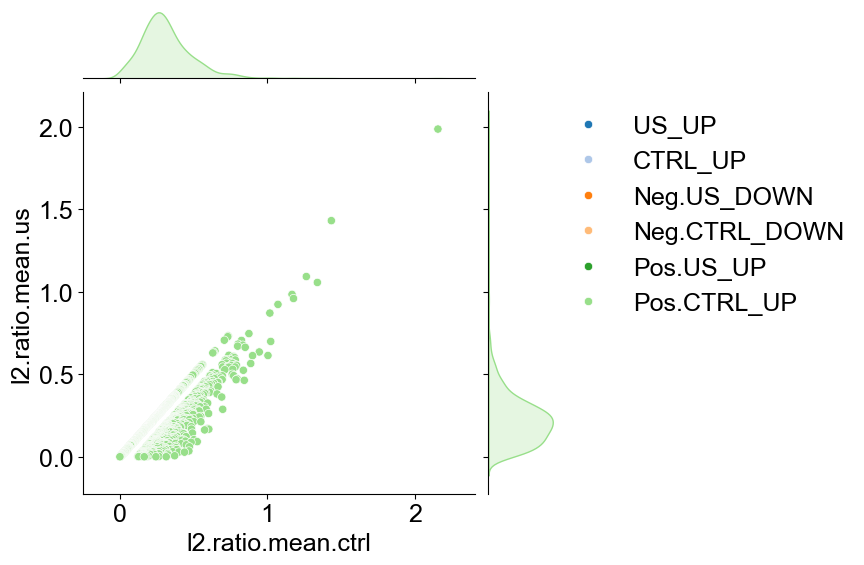

In [60]:
EXP_NAME ="exp4"
DIRECTION = "Pos.CTRL_UP"

### subset df by direction. 

df_dir = getDfDirectionSub(df, DIRECTION)

### top and bottom 10% of direction changes. 

# top quantile of delta.means
pos, pos_names, neg, neg_names = getQuantileDelta(df_dir, TOP_QUANTILE, df, False)

plot = pd.concat([pos, neg])
# fig,ax = plt.subplots(figsize=(6,6))
hue_order = ['US_UP',
             'CTRL_UP',
             'Neg.US_DOWN',
             'Neg.CTRL_DOWN',
             'Pos.US_UP',
             'Pos.CTRL_UP',
             ]

g = sns.jointplot(x="l2.ratio.mean.ctrl", y="l2.ratio.mean.us",
                  data=plot, hue="direction", hue_order=hue_order,
                  palette='tab20'
                 )
g.ax_joint.legend(frameon=False, bbox_to_anchor=(2, 1))

In [61]:
# get enh ids, linked tiles from exp1 dataset
exp1pos_enhnames, exp1pos_linkedtiles = getEnhSet(bj, exp1up)
exp1neg_enhnames, exp1neg_linkedtiles = getEnhSet(bj, exp1down)

(       l2.ratio.mean.ctrl  l2.ratio.mean.us  delta.mean
 count          675.000000        675.000000  675.000000
 mean             0.236410          0.233801   -0.002609
 std              0.130666          0.130640    0.001459
 min              0.000548          0.000044   -0.005083
 25%              0.154462          0.150937   -0.003840
 50%              0.233255          0.232261   -0.002716
 75%              0.304627          0.302285   -0.001303
 max              1.434813          1.430616   -0.000002,
        l2.ratio.mean.ctrl  l2.ratio.mean.us  delta.mean
 count          675.000000        675.000000  675.000000
 mean             0.398324          0.216579   -0.181745
 std              0.192023          0.183847    0.062716
 min              0.123491          0.000061   -0.436385
 25%              0.271149          0.086930   -0.208349
 50%              0.360903          0.174963   -0.162348
 75%              0.488994          0.302437   -0.136718
 max              2.157566    

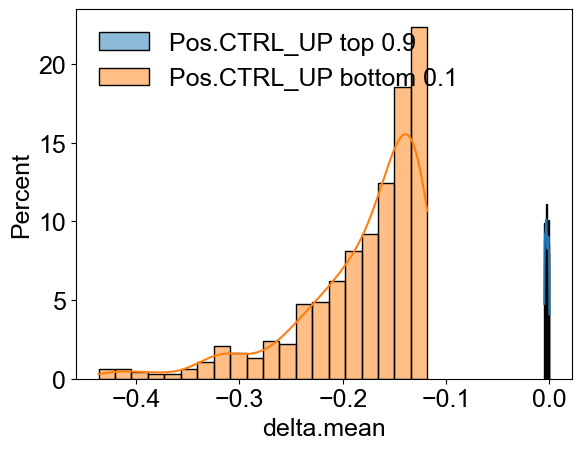

In [62]:
# remove exp 1 linked tiles
pos_names_clean = set(pos_names).difference(set(exp1pos_linkedtiles))
neg_names_clean = set(neg_names).difference(set(exp1neg_linkedtiles))

# make fasta files from quantiles. 
FA_POS, FA_NEG = makeQuantileFasta(pos_names_clean, neg_names_clean, DIRECTION, RE_MEME_CL, TOP_QUANTILE, EXP_NAME, FASTA)


# add to config
config[section][f'{CL}.{DIRECTION}.{TOP_QUANTILE}.fa'] = FA_POS
config[section][f'{CL}.{DIRECTION}.{BOTTOM_QUANTILE}.fa'] = FA_NEG

crw.write(config, cfn)

shuf = bj.loc[bj["label"] == "Shuffle"]
genome = bj.loc[bj["label"] != "Shuffle"]

fig, ax = plt.subplots()

"""
sns.histplot(x="delta.mean", data=df_dir,
             label=f"{DIRECTION}", stat="percent", kde=True,
             color="w", common_norm=False
            )
            
"""
#sns.histplot(x="delta.mean", data=shuf, label="shuffle", kde=True,
 #            stat="percent", color="grey", common_norm=False)
sns.histplot(x="delta.mean", data=pos, label=f"{DIRECTION} top {TOP_QUANTILE}",
             kde=True,common_norm=False, #color="orange", 
             stat="percent")
sns.histplot(x="delta.mean", data=neg, label=f"{DIRECTION} bottom {BOTTOM_QUANTILE}",
             kde=True,common_norm=False, #color="blue",
             stat="percent")
plt.legend(frameon=False, loc="upper left")

shuf["delta.mean"].quantile(0.975), pos["delta.mean"].describe()

pos.describe(), neg.describe()

In [63]:
OUTDIR_TOP =  runFimo(FIMO, MEME_TXT, FA_POS, DIRECTION, TOP_QUANTILE)
OUTDIR_BOTTOM =  runFimo(FIMO, MEME_TXT, FA_NEG, DIRECTION, BOTTOM_QUANTILE)

Using motif +GRGRRGGGCTGAGDG of width 15.
Using motif -GRGRRGGGCTGAGDG of width 15.
Computing q-values.
# Computing q-values.
#   Estimating pi_0 from a uniformly sampled set of 10000 p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.994725
#   Estimated pi_0=0.99798
Using motif +TCTSCSCAVRG of width 11.
Using motif -TCTSCSCAVRG of width 11.
Computing q-values.
# Computing q-values.
#   Estimating pi_0 from a uniformly sampled set of 10000 p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.993368
#   Estimated pi_0=0.998191
Using motif +KSAGSCCWGGCYS of width 13.
Using motif -KSAGSCCWGGCYS of width 13.
Computing q-values.
# Computing q-values.
#   Estimating pi_0 from a uniformly sampled set of 10000 p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.998392
#   Estimated pi_0=0.998392
Using motif +GRGRRGGGCTGAGDG of width 15.
Using motif -GRGRRGGGCTGAGDG of width 15.
Computing q-values.
# Computing q-values.
#   Estimating pi_0 from a uniformly sampled set of 10000 p-values.
#  

(238, 12)
(645, 12)


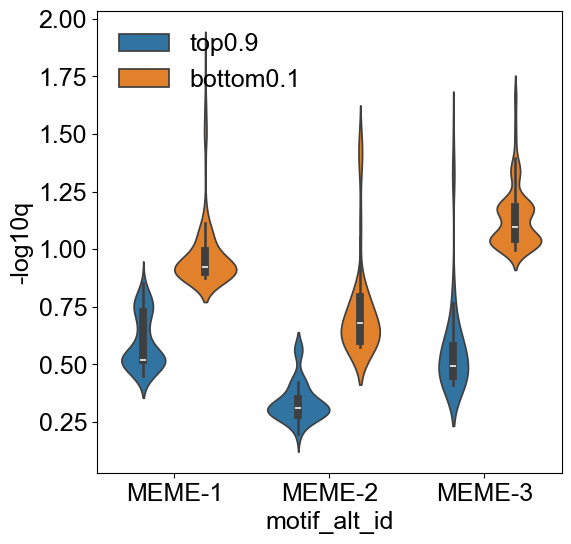

In [64]:
bottom_pred = os.path.join(OUTDIR_BOTTOM, "fimo.tsv")
top_pred = os.path.join(OUTDIR_TOP, "fimo.tsv")

tdf = pd.read_csv(top_pred, sep='\t')
tdf["quantile"] = 'top0.9'
tdf["-log10q"] = -1*np.log10(tdf["q-value"])
print(tdf.shape)
tdf.head()

bdf = pd.read_csv(bottom_pred, sep='\t')
bdf["quantile"] = 'bottom0.1'
bdf["-log10q"] = -1*np.log10(bdf["q-value"])
print(bdf.shape)
bdf.head()

# concatenate the top and bottom values
plot = pd.concat([tdf, bdf])
plot = plot.loc[~plot["motif_alt_id"].isna()]

fig, ax = plt.subplots(figsize=(6, 6))
sns.violinplot(x="motif_alt_id", y='-log10q', data=plot, hue="quantile",
               #hue_order=["bottom0.1", "top0.1"],
               order=["MEME-1", "MEME-2", "MEME-3"])
#ax.set(ylim=(-0.20,2.75))
ax.legend(frameon=False, loc='upper left')

In [65]:
IDS = ["MEME-1", "MEME-2", "MEME-3"]
VAL =  "-log10q" #"score"
for ID in IDS: 

    a = tdf.loc[tdf["motif_alt_id"]==ID, VAL]
    b = bdf.loc[bdf["motif_alt_id"]==ID, VAL]
    print(ID, stats.mannwhitneyu(a,b))

MEME-1 MannwhitneyuResult(statistic=0.0, pvalue=2.777057492342468e-46)
MEME-2 MannwhitneyuResult(statistic=0.0, pvalue=1.425516581727862e-25)
MEME-3 MannwhitneyuResult(statistic=1304.0, pvalue=1.6120169822189526e-37)


In [66]:
plot.groupby(["motif_alt_id", "quantile"]).count()

motif_id  sequence_name  start  stop  strand  score  \
motif_alt_id quantile                                                         
MEME-1       bottom0.1       237            237    237   237     237    237   
             top0.9           95             95     95    95      95     95   
MEME-2       bottom0.1       116            116    116   116     116    116   
             top0.9           52             52     52    52      52     52   
MEME-3       bottom0.1       289            289    289   289     289    289   
             top0.9           88             88     88    88      88     88   

                        p-value  q-value  matched_sequence  -log10q  
motif_alt_id quantile                                                
MEME-1       bottom0.1      237      237               237      237  
             top0.9          95       95                95       95  
MEME-2       bottom0.1      116      116               116      116  
             top0.9          52       52                52       52  
MEME-3       bottom0.1      289      289               289      289  
             top0.9          88       88                88       88

In [67]:
# how many significant motifs in each group?
plot.loc[plot["q-value"]<=0.05].groupby(["motif_alt_id", "quantile"]).count()

motif_id  sequence_name  start  stop  strand  score  \
motif_alt_id quantile                                                         
MEME-1       bottom0.1        13             13     13    13      13     13   
MEME-2       bottom0.1         8              8      8     8       8      8   
MEME-3       bottom0.1        38             38     38    38      38     38   
             top0.9            5              5      5     5       5      5   

                        p-value  q-value  matched_sequence  -log10q  
motif_alt_id quantile                                                
MEME-1       bottom0.1       13       13                13       13  
MEME-2       bottom0.1        8        8                 8        8  
MEME-3       bottom0.1       38       38                38       38  
             top0.9           5        5                 5        5

# luciferase tested elements. 

## load experiment data 

In [68]:
LUC="/wynton/group/ahituv/fongsl/projects/US/data/validation_luc/Candidate_ID_table_luc.txt"

luc = pd.read_csv(LUC, sep='\t')

luc_names = list(luc["insert"])  # list of tiles tested in luciferase


# successful results where luciferase direction matches 
success = ["Hepg2_D1", "Hepg2_D2", "Hepg2_D3", "Hepg2_D8", "Hepg2_U1"]

# annotate dataframe with sucesses
luc["success"] = False
luc.loc[luc["Sample name"].isin(success), "success"] = True
#luc.loc[~luc["Sample name"].str.contains(CL), "success"] = "other-cl"

luc.rename(columns = {"insert":"sequence_name", 
                     "Sample name": 'label_id'}, inplace=True)
luc

,Sample ID,label_id,sequence_name,type.x,label,pval,logFC,control_ratio,ultrasound_ratio,dir,sequence,success
0,1,BJ_D1,hob_atac_up_chr22:41305657-41305926,"top_5_significant, top_5_largest_logFC, pval_p...",Differential_ATAC,0.001828,-0.387330,1.496837,1.144397,DOWN,AGTAGGTTTCTAACTGCAGAAAGCAGAATGGCAGTAGAAGGAGGAC...,False
1,2,BJ_D2,hepg2_atac_down_chr10:109895366-109895635,"top_5_significant, top_5_largest_logFC, pval_p...",Differential_ATAC,0.000797,-0.373681,1.300464,1.003713,DOWN,GGAAGATCCGCAGGGTTTACCTAGACTTCTCCATCAGCAAAGGCAA...,False
2,3,BJ_D3,hob_atac_up_chr3:127734774-127735043,logFC<-0.25_peakp<0.05_responseTrue,Differential_ATAC,0.009797,-0.255964,1.233940,1.033336,DOWN,ATCTCTCCTCAGGTGACTAAGCCAGCCAGTCATGGCAGGCACACGG...,False
3,4,BJ_D4,SYNTHETIC:_Added_TGTAACAA_AGGTGTCA_AAGACCCCTC_...,"top_5_significant, top_5_largest_logFC",Synthetic,0.000569,-0.221765,1.269305,1.088449,DOWN,GACAGGTGTCATTTGTCTGGCAACGTGTCTGGAATAACTTCCAAGA...,False
4,5,BJ_D5,hob_k27ac_up_chr12:32115256-32115525,"top_3_largest_logFC_bc100, top_5_barcodes",Differential_H3K27ac,0.002897,-0.155360,1.268955,1.139405,DOWN,TAAATTAATAGTTTTCCCTTCTTCTCCCACAGTTCTGTCTCTGTTG...,False
5,6,BJ_D6,SYNTHETIC:_Added_AGGGGAGGTATT_AGCAACCA_CCCCCGC...,top_5_barcodes,Synthetic,0.003760,-0.124638,1.305544,1.197490,DOWN,GACGCTTACTGTGTACCCCCGCCCCTGTCTGGAATAACTTCCAAGA...,False
6,7,BJ_D7,SYNTHETIC:_Added_GCCCGGGGG_GGCCATTAAC_TATGACTC...,top_5_significant,Synthetic,0.000707,-0.169443,1.424512,1.266656,DOWN,GACGCTTACTGTGTAGAGGCCAACCCCCCCCCAATAACTTCCAAGA...,False
7,8,BJ_D8,SYNTHETIC:_Added_GTGGTGTGTG_CGCCACGGCGGGGGTGGA...,top_5_largest_logFC,Synthetic,0.004943,-0.197340,1.473556,1.285172,DOWN,GACGCTTACTGTGTAGAGGCGTGGTGTGTGGGAATAGCAGCTGAGA...,False
8,9,BJ_D9,SYNTHETIC:_The_motif_GGGGCGGGG_was_added_in_Po...,top_5_largest_logFC,Synthetic,0.003534,-0.294115,1.358003,1.107549,DOWN,GACGCTTACTGTGTAGAGGCCAACGTGTCTGGAATAACTTCCAAGA...,False
9,10,BJ_U1,hob_k27ac_up_chr2:145036567-145036836,"top_5_significant, top_3_significant_bc100, to...",Differential_H3K27ac,0.000716,0.107081,1.211559,1.304906,UP,CTAGTTCATAGTTGGTCCAGTTTTCCCATTTTCTAAACCACAACTA...,False


## make fasta

In [69]:
LUC_FA = LUC.strip(".txt") + '.fa'
filterWriteFasta(LUC_FA, FASTA, luc_names)

## fimo

In [70]:
OUTDIR_LUC =  runFimo(FIMO, MEME_TXT, LUC_FA, "Luc", "all")

Using motif +GRGRRGGGCTGAGDG of width 15.
Using motif -GRGRRGGGCTGAGDG of width 15.
Computing q-values.
# Computing q-values.
#   Estimating pi_0 from a uniformly sampled set of 10000 p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.944255
#   Estimated pi_0=0.945333
Using motif +TCTSCSCAVRG of width 11.
Using motif -TCTSCSCAVRG of width 11.
Computing q-values.
# Computing q-values.
#   Estimating pi_0 from a uniformly sampled set of 10000 p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.921311
#   Estimated pi_0=0.925909
Using motif +KSAGSCCWGGCYS of width 13.
Using motif -KSAGSCCWGGCYS of width 13.
Computing q-values.
# Computing q-values.
#   Estimating pi_0 from a uniformly sampled set of 10000 p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.89931
#   Estimated pi_0=0.909242


In [71]:
pred = os.path.join(OUTDIR_LUC, "fimo.tsv")

tdf = pd.read_csv(pred, sep='\t')
tdf["quantile"] = 'LUC.matches'
tdf["-log10q"]  = -1*np.log10(tdf["q-value"])
print(tdf.shape)
tdf = tdf.loc[~tdf["motif_alt_id"].isna()]
tdf

(37, 12)


,motif_id,motif_alt_id,sequence_name,start,stop,strand,score,p-value,q-value,matched_sequence,quantile,-log10q
0,GRGRRGGGCTGAGDG,MEME-1,hob_k27ac_down_chr16:2904526-2904795,20.0,34.0,+,20.09910,9.960000e-08,0.00130,GAGGGGGCCTGTGTG,LUC.matches,2.886057
1,KSAGSCCWGGCYS,MEME-3,hob_k27ac_down_chr15:75844211-75844480,21.0,33.0,+,19.33030,1.760000e-07,0.00223,TGAGCCCAGGCCG,LUC.matches,2.651695
2,KSAGSCCWGGCYS,MEME-3,hob_atac_up_chr22:30250826-30251095,183.0,195.0,-,15.92660,3.480000e-06,0.02200,GGAGGCCAGCCTG,LUC.matches,1.657577
3,TCTSCSCAVRG,MEME-2,hob_k27ac_down_chr15:75844211-75844480,210.0,220.0,+,16.24770,3.590000e-06,0.04670,TCTCCCCCGGG,LUC.matches,1.330683
4,GRGRRGGGCTGAGDG,MEME-1,hepg2_atac_up_chr16:85650086-85650355,147.0,161.0,+,14.93690,4.000000e-06,0.02140,GAGGGAGGCTGAGGG,LUC.matches,1.669586
5,GRGRRGGGCTGAGDG,MEME-1,k562_atac_up_chr13:25406382-25406651,217.0,231.0,+,14.56760,4.900000e-06,0.02140,AAGGAGGGCTCACAG,LUC.matches,1.669586
6,GRGRRGGGCTGAGDG,MEME-1,bj_atac_down_chr1:147640884-147641153,69.0,83.0,-,13.33330,9.060000e-06,0.02960,GGAGATGGCTGTGTG,LUC.matches,1.528708
7,GRGRRGGGCTGAGDG,MEME-1,hob_atac_up_chr17:538152-538421,27.0,41.0,-,12.22520,1.510000e-05,0.03510,GGGGATGGCACACTG,LUC.matches,1.454693
8,KSAGSCCWGGCYS,MEME-3,hob_k27ac_down_chr15:75844211-75844480,217.0,229.0,-,11.92660,1.520000e-05,0.05540,GCAGCCAGGCCCG,LUC.matches,1.256490
9,GRGRRGGGCTGAGDG,MEME-1,bj_atac_down_chr1:147640884-147641153,61.0,75.0,+,12.01800,1.660000e-05,0.03510,GAAGAGAGCACACAG,LUC.matches,1.454693


In [76]:
luc_fimo = pd.merge(luc[["label_id", "sequence_name", "success"]],
                    tdf, how="right").sort_values(by='success', ascending=False)
luc_fimo['label_id_success'] = luc_fimo["label_id"] + ".success." + luc_fimo['success'].map(str)
luc_fimo

,label_id,sequence_name,success,motif_id,motif_alt_id,start,stop,strand,score,p-value,q-value,matched_sequence,quantile,-log10q,label_id_success
25,Hepg2_D1,hob_atac_up_chr17:538152-538421,True,KSAGSCCWGGCYS,MEME-3,14.0,26.0,+,8.52294,6.440000e-05,0.06280,GGAGGCAATGCTG,LUC.matches,1.202040,Hepg2_D1.success.True
32,Hepg2_D1,hob_atac_up_chr17:538152-538421,True,TCTSCSCAVRG,MEME-2,83.0,93.0,+,7.73394,9.500000e-05,0.15400,CCTGCCCCGGG,LUC.matches,0.812479,Hepg2_D1.success.True
28,Hepg2_D2,hob_k27ac_down_chr7:66627968-66628237,True,TCTSCSCAVRG,MEME-2,230.0,240.0,-,7.93578,7.480000e-05,0.15400,TCAGCGCAGGG,LUC.matches,0.812479,Hepg2_D2.success.True
7,Hepg2_D1,hob_atac_up_chr17:538152-538421,True,GRGRRGGGCTGAGDG,MEME-1,27.0,41.0,-,12.22520,1.510000e-05,0.03510,GGGGATGGCACACTG,LUC.matches,1.454693,Hepg2_D1.success.True
23,Hepg2_D1,hob_atac_up_chr17:538152-538421,True,KSAGSCCWGGCYS,MEME-3,66.0,78.0,+,8.88991,5.400000e-05,0.05700,GCAGCACCAGCTC,LUC.matches,1.244125,Hepg2_D1.success.True
0,Hepg2_U6,hob_k27ac_down_chr16:2904526-2904795,False,GRGRRGGGCTGAGDG,MEME-1,20.0,34.0,+,20.09910,9.960000e-08,0.00130,GAGGGGGCCTGTGTG,LUC.matches,2.886057,Hepg2_U6.success.False
20,Hepg2_U5,hepg2_atac_up_chr16:85650086-85650355,False,KSAGSCCWGGCYS,MEME-3,118.0,130.0,+,9.32110,4.370000e-05,0.05540,GCAGCCCAAGGCG,LUC.matches,1.256490,Hepg2_U5.success.False
21,Hepg2_U6,hob_k27ac_down_chr16:2904526-2904795,False,KSAGSCCWGGCYS,MEME-3,107.0,119.0,-,9.10092,4.810000e-05,0.05540,GGAGGAGAGGCTG,LUC.matches,1.256490,Hepg2_U6.success.False
22,BJ_U9,hob_atac_up_chr7:4689923-4690192,False,GRGRRGGGCTGAGDG,MEME-1,133.0,147.0,+,9.41441,4.950000e-05,0.07190,GGGAAGAGCTGTGAT,LUC.matches,1.143271,BJ_U9.success.False
24,BJ_U5,k562_atac_up_chr7:1917897-1918166,False,GRGRRGGGCTGAGDG,MEME-1,98.0,112.0,+,8.87387,6.140000e-05,0.08030,GGGAGGGGCCCAGGC,LUC.matches,1.095284,BJ_U5.success.False


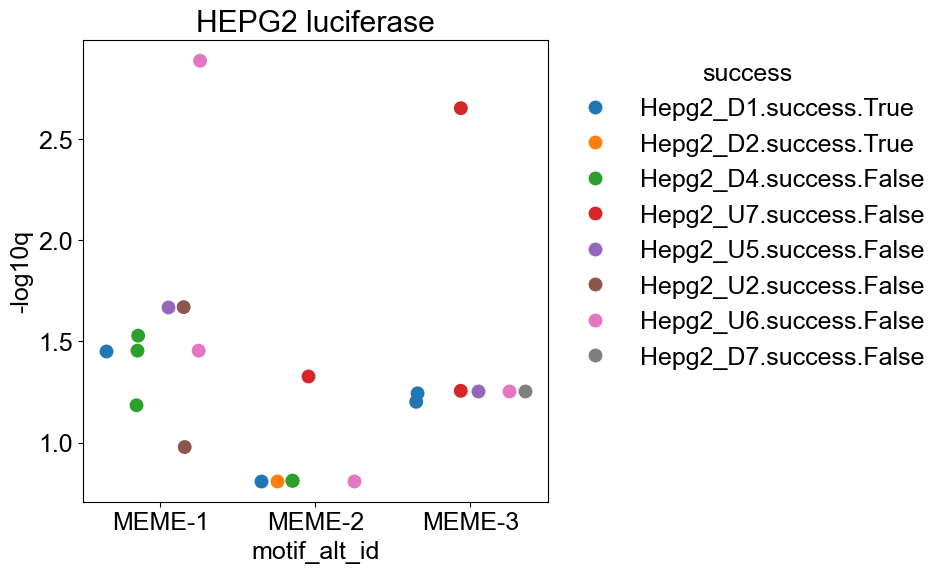

In [81]:
x="motif_alt_id"
y="-log10q"
hue="label_id_success"
order=["MEME-1", "MEME-2", "MEME-3"]
data=luc_fimo.loc[luc_fimo["label_id"].str.contains("Hepg2")].sort_values(by='success', ascending=False)

fig, ax = plt.subplots(figsize=(6,6))
sns.stripplot(x=x,y=y, hue=hue, order=order, jitter=True,
              data=data, dodge = True, s=10)
ax.set(title=f"{CL} luciferase")
ax.legend(title="success", frameon=False, bbox_to_anchor=(1,1))

In [82]:
data.reset_index()

,index,label_id,sequence_name,success,motif_id,motif_alt_id,start,stop,strand,score,p-value,q-value,matched_sequence,quantile,-log10q,label_id_success
0,25,Hepg2_D1,hob_atac_up_chr17:538152-538421,True,KSAGSCCWGGCYS,MEME-3,14.0,26.0,+,8.52294,6.440000e-05,0.06280,GGAGGCAATGCTG,LUC.matches,1.202040,Hepg2_D1.success.True
1,28,Hepg2_D2,hob_k27ac_down_chr7:66627968-66628237,True,TCTSCSCAVRG,MEME-2,230.0,240.0,-,7.93578,7.480000e-05,0.15400,TCAGCGCAGGG,LUC.matches,0.812479,Hepg2_D2.success.True
2,7,Hepg2_D1,hob_atac_up_chr17:538152-538421,True,GRGRRGGGCTGAGDG,MEME-1,27.0,41.0,-,12.22520,1.510000e-05,0.03510,GGGGATGGCACACTG,LUC.matches,1.454693,Hepg2_D1.success.True
3,23,Hepg2_D1,hob_atac_up_chr17:538152-538421,True,KSAGSCCWGGCYS,MEME-3,66.0,78.0,+,8.88991,5.400000e-05,0.05700,GCAGCACCAGCTC,LUC.matches,1.244125,Hepg2_D1.success.True
4,32,Hepg2_D1,hob_atac_up_chr17:538152-538421,True,TCTSCSCAVRG,MEME-2,83.0,93.0,+,7.73394,9.500000e-05,0.15400,CCTGCCCCGGG,LUC.matches,0.812479,Hepg2_D1.success.True
5,12,Hepg2_D4,bj_atac_down_chr1:147640884-147641153,False,TCTSCSCAVRG,MEME-2,79.0,89.0,+,9.17431,3.150000e-05,0.15400,TCTCCCCGGGG,LUC.matches,0.812479,Hepg2_D4.success.False
6,3,Hepg2_U7,hob_k27ac_down_chr15:75844211-75844480,False,TCTSCSCAVRG,MEME-2,210.0,220.0,+,16.24770,3.590000e-06,0.04670,TCTCCCCCGGG,LUC.matches,1.330683,Hepg2_U7.success.False
7,4,Hepg2_U5,hepg2_atac_up_chr16:85650086-85650355,False,GRGRRGGGCTGAGDG,MEME-1,147.0,161.0,+,14.93690,4.000000e-06,0.02140,GAGGGAGGCTGAGGG,LUC.matches,1.669586,Hepg2_U5.success.False
8,5,Hepg2_U2,k562_atac_up_chr13:25406382-25406651,False,GRGRRGGGCTGAGDG,MEME-1,217.0,231.0,+,14.56760,4.900000e-06,0.02140,AAGGAGGGCTCACAG,LUC.matches,1.669586,Hepg2_U2.success.False
9,6,Hepg2_D4,bj_atac_down_chr1:147640884-147641153,False,GRGRRGGGCTGAGDG,MEME-1,69.0,83.0,-,13.33330,9.060000e-06,0.02960,GGAGATGGCTGTGTG,LUC.matches,1.528708,Hepg2_D4.success.False


In [83]:
table = data.groupby(["motif_alt_id", "label_id", "success"])['-log10q'].max().reset_index(
).pivot(index="motif_alt_id", columns=[ "label_id",], values="-log10q")#.fillna(0)

<Axes: xlabel='label_id', ylabel='motif_alt_id'>

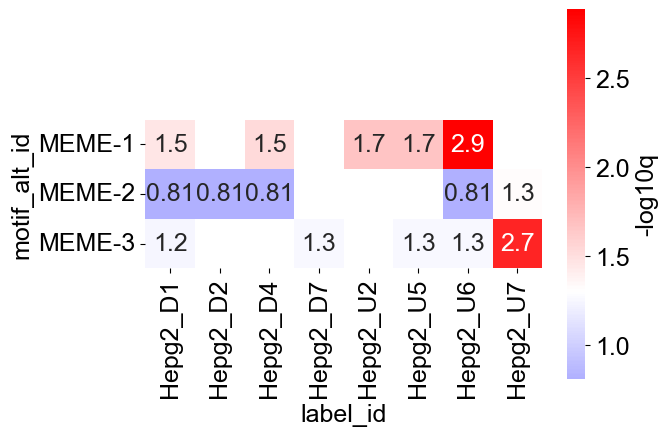

In [85]:
sns.heatmap(table, square=True, cmap="bwr", 
            annot=True, 
            cbar_kws={"label":"-log10q"}, center=1.3
           )